In [1]:
using Pkg

In [ ]:
Pkg.activate("../nb_examples")
Pkg.add("IceFloeTracker")
Pkg.add("Plots")

In [5]:
using IceFloeTracker

[ Info: Precompiling IceFloeTracker [04643c7a-9ac6-48c5-822f-2704f9e70bd3] (cache misses: wrong dep version loaded (2), dep missing source (2))


In [24]:
img_loc = "../notebook-example-images/"
case = "018-baffin_bay-100km-20120915.aqua"
case = "006-baffin_bay-100km-20220530.aqua"

"006-baffin_bay-100km-20220530.aqua"

# Preliminaries: Land and cloud mask generation

In [25]:
## 1. Landmask generation
# Note types of images that can be created
# Need to swap 1 and 0
# Question of handling different types of landmask

landmask_imgs = create_landmask(
    load(joinpath(img_loc, case*".landmask.250m.tiff")))

(dilated = Bool[1 1 … 1 1; 1 1 … 1 1; … ; 1 1 … 1 1; 1 1 … 1 1], non_dilated = Bool[1 1 … 1 1; 1 1 … 1 1; … ; 1 1 … 1 1; 1 1 … 1 1])

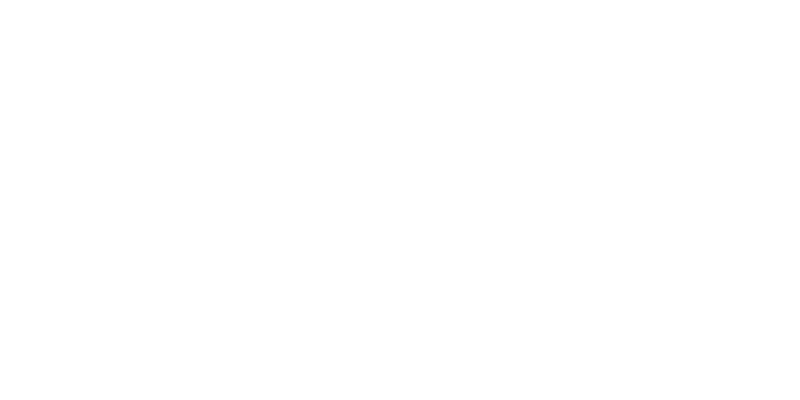

In [26]:
using Images
Images.mosaicview(Gray.(landmask_imgs.non_dilated), Gray.(landmask_imgs.dilated), nrow=1)

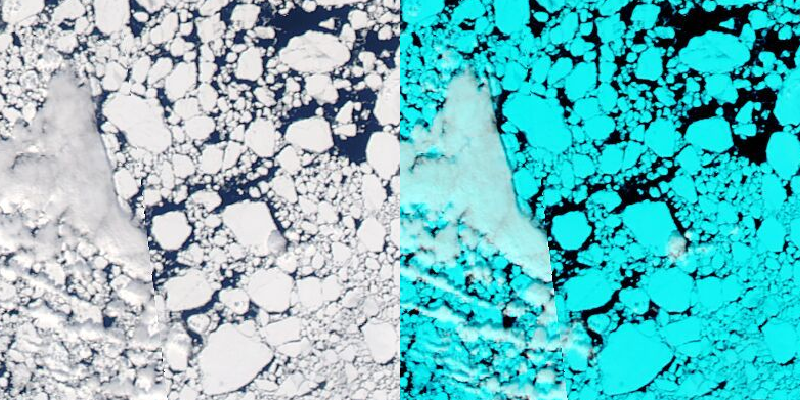

In [27]:
## 2. Loading true and falsecolor images
# These example images load as RGBA(N0f8): normed integer 8 bit representation
tc_img = load(joinpath(img_loc, case*".truecolor.250m.tiff"))
fc_img = load(joinpath(img_loc, case*".falsecolor.250m.tiff"))
Images.mosaicview(tc_img, fc_img, nrow=1)

In [28]:
typeof(tc_img)

Matrix{RGBA{N0f8}} (alias for Array{RGBA{Normed{UInt8, 8}}, 2})

In [65]:
cloudmask_params = (
    prelim_threshold= 53/255.,
    band_7_threshold=130/255.,
    band_2_threshold=169/255.,
    ratio_lower=0.,
    ratio_upper=0.53)

cloudmask_init = IceFloeTracker.create_cloudmask(fc_img; cloudmask_params...);
cloudmask = IceFloeTracker.MorphSE.closing(cloudmask_init, IceFloeTracker.strel_diamond((5, 5)));

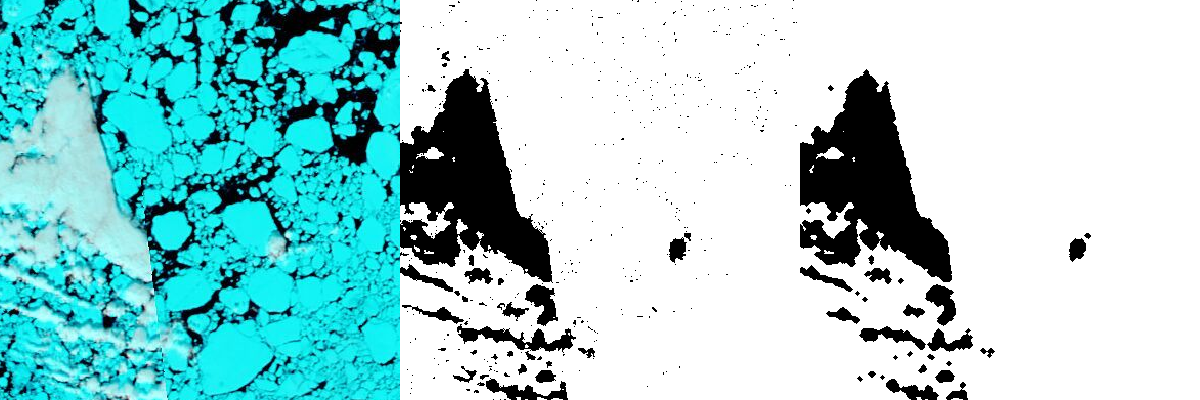

In [66]:
Images.mosaicview(fc_img, Gray.(cloudmask_init), Gray.(cloudmask), nrow=1)

# Preprocessing
The preprocessing functions prepare the image for segmentation. These operations are Image Filters: they take in an image, apply adjustments of some sort, then produce an image. 

My task for now: identify components of imsharpen and imsharpen gray that can be be separated, and reframed in the ImageFilter sense to show similarities between the two methods.

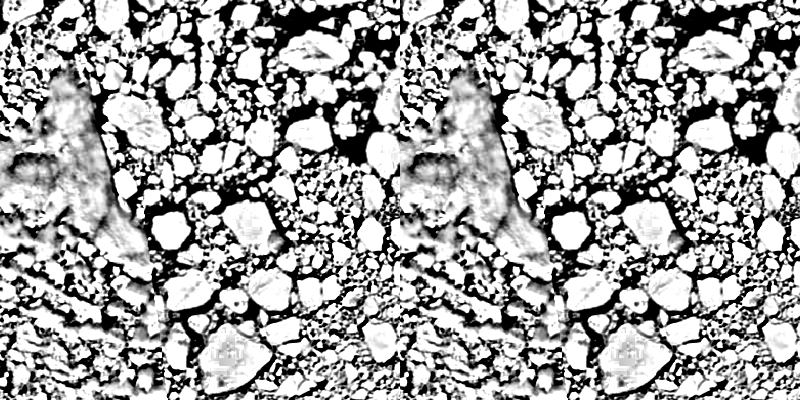

In [74]:
# set parameters for imsharpen
imsharp_params = (
    lambda = 0.1,
    kappa = 75,
    niters = 3,
    nbins = 255,
    rblocks = 10,
    cblocks = 10,
    clip = 0.86,
    smoothing_param=10,
    intensity=2.0
    )

# a. apply imsharpen to truecolor image using non-dilated landmask
sharpened_truecolor_image = IceFloeTracker.imsharpen(RGB.(float64.(tc_img)), landmask_imgs.non_dilated, imsharp_params...)
# 7.579775 seconds (3.86 M allocations: 3.822 GiB, 9.46% gc time, 34.64% compilation time)

# b. apply imsharpen to sharpened truecolor img using dilated landmask
sharpened_gray_truecolor_image = IceFloeTracker.imsharpen_gray(sharpened_truecolor_image, landmask_imgs.dilated)

Images.mosaicview(sharpened_truecolor_image, sharpened_gray_truecolor_image, nrow=1)

# Other methods for segmentation to note

In [ ]:
Pkg.add("ImageView")
using ImageSegmentation
using ImageView

In [146]:
seg = unseeded_region_growing(sharpened_gray_truecolor_image .* cloudmask, 0.05)

Segmented Image with:
  labels map: 400×400 Matrix{Int64}
  number of labels: 15

In [147]:
seg.segment_pixel_count

Dict{Int64, Int64} with 15 entries:
  5  => 3799
  12 => 4137
  8  => 4030
  1  => 51930
  6  => 3311
  11 => 3986
  9  => 59135
  14 => 3743
  3  => 3276
  7  => 3530
  4  => 3383
  13 => 4194
  15 => 2865
  2  => 3560
  10 => 5121

In [143]:
using Random

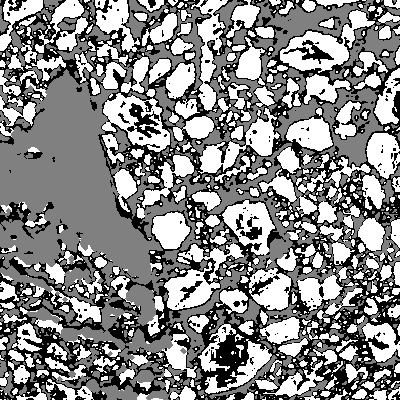

In [148]:
function get_random_color(seed)
    Random.seed!(seed)
    rand(RGB{N0f8})
end
Images.mosaicview(Gray.((labels_map(seg) .== 9) + 0.5*(labels_map(seg) .== 1)))

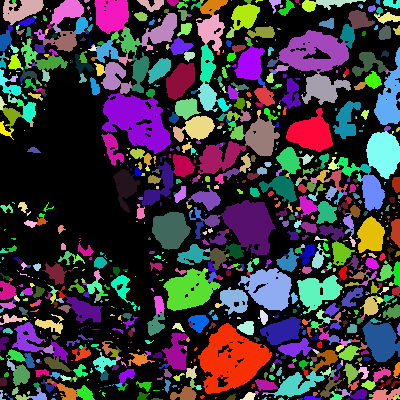

In [202]:
bw = Gray.(sharpened_gray_truecolor_image .* cloudmask) .< 0.75
dist = 1 .- distance_transform(feature_transform(bw));
markers = label_components(dist .< -0.9);
segments = watershed(dist, markers);
map(i->get_random_color(i), labels_map(segments)) .* (1 .-bw)

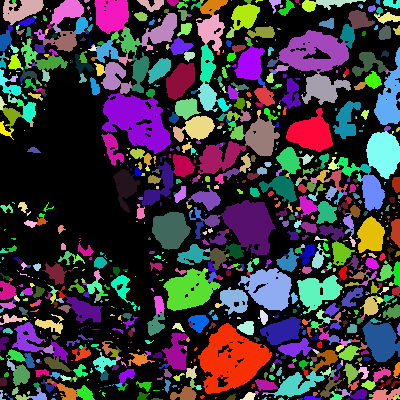

In [201]:
bw = Gray.(sharpened_truecolor_image .* cloudmask) .< 0.75
dist = 1 .- distance_transform(feature_transform(bw));
markers = label_components(dist .< -0.9);
segments = watershed(dist, markers);
map(i->get_random_color(i), labels_map(segments)) .* (1 .-bw)

In [180]:
maximum(dist)


39.698866482558415